In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import auc
import seaborn as sns

In [2]:
targets = [2, 1, 0, -1, -2, -3, -4, -5, -6, -7, -8]
targets = [10**x for x in targets]
evals = [1, 223, 445, 668, 890, 1112, 1334, 1557, 1779, 2001, 2223, 2445, 2668, 2890,
         3112, 3334, 3557, 3779, 4001, 4223, 4445, 4668, 4890, 5001]
functions = list(np.arange(25, 44))

In [3]:
algo_dcma = ['DCMA_6_2.2202_F', 'DCMA_8_4.0305_F', 'DCMA_6_4.029_T', 'DCMA_7_4.8509_T', 'DCMA_14_1.4688_T', 'DCMA_23_3.6117_F',
             'DCMA_13_2.2287_F', 'DCMA_27_4.1712_T']
algo_pso = ['PSO_30_I', 'PSO_32_I', 'PSO_35_I']
algo_combinations = []
for i in range(4):
    algo_combinations.append((algo_dcma[i], algo_pso[0]))
for i in range(4,7):
    algo_combinations.append((algo_dcma[i], algo_pso[1]))
algo_combinations.append((algo_dcma[7], algo_pso[2]))
#algo_combinations.append(('DiagonalCMA', 'PSO'))
algo_combinations   #reqd. config settings

[('DCMA_6_2.2202_F', 'PSO_30_I'),
 ('DCMA_8_4.0305_F', 'PSO_30_I'),
 ('DCMA_6_4.029_T', 'PSO_30_I'),
 ('DCMA_7_4.8509_T', 'PSO_30_I'),
 ('DCMA_14_1.4688_T', 'PSO_32_I'),
 ('DCMA_23_3.6117_F', 'PSO_32_I'),
 ('DCMA_13_2.2287_F', 'PSO_32_I'),
 ('DCMA_27_4.1712_T', 'PSO_35_I')]

In [3]:
df_auc = pd.read_csv('performance_auc.csv', index_col=[0])   #aucs of default combinations (for comparison with default variant)

In [4]:
import re
c = "'"
for col in df_auc.columns:
    new_col = re.sub(c, '', col)
    df_auc.rename(columns = {col:new_col}, inplace = True)

In [8]:
#df_auc.head()

In [12]:
df_tune = pd.DataFrame(columns=algo_combinations, index=functions)
df_tune = df_tune.fillna(0)
df_tune = df_tune.astype(float)
df_tune.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)"
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def ecdf(func, algo_tuple, targets=targets, evals=evals):
    df = pd.read_csv(r'filepath/FVSample-10DF'+str(func)+'.csv')  #original target sample csv file based on logs uploaded to iohanalyzer
    
    algo1 = algo_tuple[0]
    algo2 = algo_tuple[1]
    #name_algo1 = rename(algo1)
    #name_algo2 = rename(algo2)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    pts_algo1 = []
    pts_algo2 = []
    pseudo = []
    
    
    for feval in evals:
        tar_tot1 = 0
        tar_tot2 = 0
        for target in targets:
            total1 = 0
            total2 = 0
            for i in range(4, 29):
                if float(df[df['ID']==algo1][df['runtime']==feval].iloc[:, i]) <= target:
                    total1 += 1
                if float(df[df['ID']==algo2][df['runtime']==feval].iloc[:, i]) <= target:
                    total2 += 1
            total1 = total1/25
            total2 = total2/25
            tar_tot1 += total1
            tar_tot2 += total2
        tar_tot1 = tar_tot1/len(targets)
        tar_tot2 = tar_tot2/len(targets)
        pts_algo1.append(tar_tot1)
        pts_algo2.append(tar_tot2)
        
    for i in range(len(pts_algo1)):
        if pts_algo1[i] >= pts_algo2[i]:
            pseudo.append((pts_algo1[i], algo1))
        else:
            pseudo.append((pts_algo2[i], algo2))
     
    pts_pseudo = [x[0] for x in pseudo]
    
    #print(pseudo)
    
    ax[0].plot(evals, pts_algo1, color='blue', marker='o')
    ax[0].plot(evals, pts_algo2, color='red', marker='^')
    ax[0].legend([algo1, algo2])
    ax[0].set_title('ECDF of '+algo1+' and\n'+algo2+' on F'+str(func))
    ax[0].set_xlabel('Function evaluations')
    ax[0].set_ylabel('Proportion of runs')
    #ax[0].set_xscale('log')
    #ax[0].invert_xaxis()
    
    ax[1].plot(evals, pts_pseudo, color='green', marker='o', alpha=0.6)
    ####
                
    area = auc(evals, pts_pseudo)
    df_tune.loc[func][algo_tuple] = area
    area = round(area, 2)
    
        
    ax[1].set_title('ECDF of pseudo algorithm on F'+str(func)+'\nAUC: '+str(area))
    
    ax[1].set_xlabel('Function evaluations')
    ax[1].set_ylabel('Proportion of runs')
    #ax[1].invert_xaxis()
    #ax[1].set_xscale('log')
    #area = auc(evals, pts_pseudo)
    #area = round(area, 2)
    #ax[1].text(3000, 0.05, r"AUC: "+str(area))
    
    
    fig.tight_layout()
    #plt.show()
    #print(pseudo)
    #area = integrate(evals, pts_pseudo)
    
    #print("AUC: ", auc(evals, pts_pseudo))
    plt.savefig(r'graphs_tune/'+str(func)+'_'+algo1+'_'+algo2+'.pdf')
    print(func, algo_tuple)

In [14]:
for func in functions:
    for algo_tuple in algo_combinations:
        ecdf(func, algo_tuple)

C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


25 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


26 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


27 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


29 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


30 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


31 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


32 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


33 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


34 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


35 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


36 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


37 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


38 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


39 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


40 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


41 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


42 ('DCMA_27_4.1712_T', 'PSO_35_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_6_2.2202_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_8_4.0305_F', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_6_4.029_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_7_4.8509_T', 'PSO_30_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_14_1.4688_T', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_23_3.6117_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_13_2.2287_F', 'PSO_32_I')


C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\NAVEEN\Anaconda3\envs\newtf\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


43 ('DCMA_27_4.1712_T', 'PSO_35_I')


In [15]:
df_tune.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)"
25,1880.045455,2080.447273,1821.860000,2025.496364,2994.389091,3848.480000,3278.043636,3866.263636
26,510.716364,584.249091,447.683636,524.858182,670.712727,777.381818,732.123636,748.690909
27,4131.352727,4427.103636,4150.345455,4341.458182,4539.012727,4405.720000,4185.878182,4347.134545
28,867.109091,863.067273,883.267273,864.074545,861.445455,842.850909,863.063636,833.149091
29,3753.523636,4031.518182,3131.316364,4171.309091,3964.423636,3670.338182,3970.085455,3549.881818


In [35]:
#df_tune.idxmax(axis=1)

In [20]:
df_tune.to_csv('performance_tune.csv')

In [5]:
df_tune = pd.read_csv('performance_tune.csv', index_col=[0])

In [6]:
for col in df_tune.columns:
    new_col = re.sub(c, '', col)
    df_tune.rename(columns = {col:new_col}, inplace = True)

In [7]:
df_tune.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)"
25,1880.045455,2080.447273,1821.860000,2025.496364,2994.389091,3848.480000,3278.043636,3866.263636
26,510.716364,584.249091,447.683636,524.858182,670.712727,777.381818,732.123636,748.690909
27,4131.352727,4427.103636,4150.345455,4341.458182,4539.012727,4405.720000,4185.878182,4347.134545
28,867.109091,863.067273,883.267273,864.074545,861.445455,842.850909,863.063636,833.149091
29,3753.523636,4031.518182,3131.316364,4171.309091,3964.423636,3670.338182,3970.085455,3549.881818


In [8]:
df_tune_n = df_tune.join(df_auc['(DiagonalCMA, PSO)'])/5000

In [9]:
df_tune_n.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)","(DiagonalCMA, PSO)"
25,0.376009,0.416089,0.364372,0.405099,0.598878,0.769696,0.655609,0.773253,0.506676
26,0.102143,0.116850,0.089537,0.104972,0.134143,0.155476,0.146425,0.149738,0.140768
27,0.826271,0.885421,0.830069,0.868292,0.907803,0.881144,0.837176,0.869427,0.923884
28,0.173422,0.172613,0.176653,0.172815,0.172289,0.168570,0.172613,0.166630,0.172128
29,0.750705,0.806304,0.626263,0.834262,0.792885,0.734068,0.794017,0.709976,0.820518


In [13]:
df_tune_n.sum(axis=0)

(DCMA_6_2.2202_F, PSO_30_I)      9.849188
(DCMA_8_4.0305_F, PSO_30_I)     10.025355
(DCMA_6_4.029_T, PSO_30_I)       9.733885
(DCMA_7_4.8509_T, PSO_30_I)     10.004463
(DCMA_14_1.4688_T, PSO_32_I)     9.933358
(DCMA_23_3.6117_F, PSO_32_I)     9.639855
(DCMA_13_2.2287_F, PSO_32_I)     9.998000
(DCMA_27_4.1712_T, PSO_35_I)     9.370397
(DiagonalCMA, PSO)              10.510364
dtype: float64

In [10]:
col_sum = {}
for col in df_tune_n.columns:
    col_sum[col] = df_tune_n[col].sum()
col_sum = pd.DataFrame.from_dict(col_sum, orient='index')
col_sum = col_sum.rename(columns={0: "Performance"})
col_sum = col_sum.sort_values(by=['Performance'], ascending=True)
col_sum

,Performance
"(DCMA_27_4.1712_T, PSO_35_I)",9.370397
"(DCMA_23_3.6117_F, PSO_32_I)",9.639855
"(DCMA_6_4.029_T, PSO_30_I)",9.733885
"(DCMA_6_2.2202_F, PSO_30_I)",9.849188
"(DCMA_14_1.4688_T, PSO_32_I)",9.933358
"(DCMA_13_2.2287_F, PSO_32_I)",9.998000
"(DCMA_7_4.8509_T, PSO_30_I)",10.004463
"(DCMA_8_4.0305_F, PSO_30_I)",10.025355
"(DiagonalCMA, PSO)",10.510364


In [11]:
col_sum.shape[0]

9

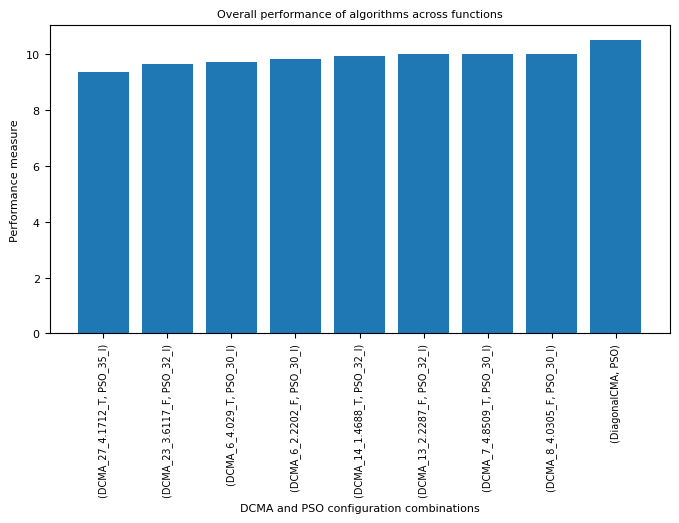

In [12]:
x = list(np.arange(9))
col_sum = col_sum.reset_index()
plt.bar(x, col_sum['Performance'])
plt.xlabel('DCMA and PSO configuration combinations', fontsize=8)
plt.ylabel('Performance measure', fontsize=8)
plt.title('Overall performance of algorithms across functions', fontsize=8)
plt.xticks(x, col_sum['index'], rotation=90, fontsize=7)
plt.yticks(fontsize=8)
figure = plt.gcf()  # get current figure
#figure.set_tight_layout(True)
figure.set_size_inches(8,4)
plt.savefig(r'ioh_logs_tune/new_algo2/ranking_tune_overall.pdf', bbox_inches='tight')
plt.show()

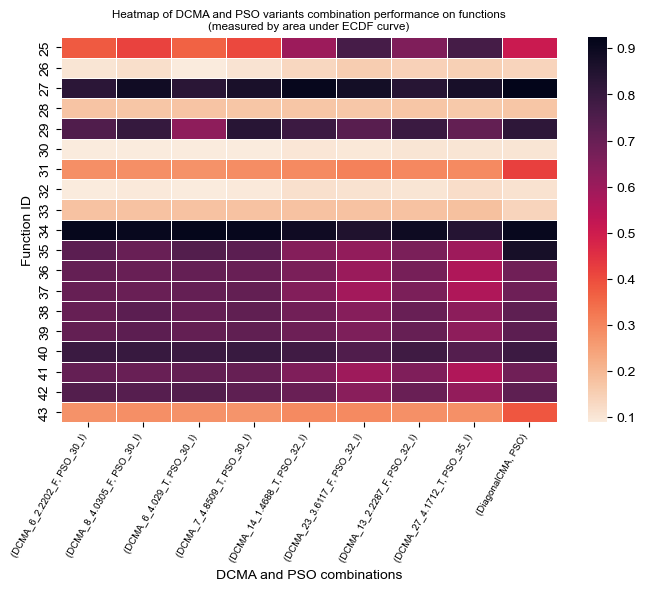

In [13]:
ax = sns.heatmap(df_tune_n, xticklabels=1, cmap="rocket_r", linewidths=0.5, linecolor='white')
sns.set(font_scale=0.7)
ax.set_xlabel('DCMA and PSO combinations')
ax.set_ylabel('Function ID')
ax.set_title('Heatmap of DCMA and PSO variants combination performance on functions\n(measured by area under ECDF curve)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize=7)
figure = plt.gcf()  # get current figure
#figure.set_tight_layout(True)
figure.set_size_inches(8,5)
plt.savefig('ioh_logs_tune/new_algo2/hmap_tune_overall_n1f.pdf', bbox_inches='tight')
plt.show()

In [14]:
df_tune_n2 = df_tune.join(df_auc['(DiagonalCMA, PSO)'])

In [15]:
df_tune_n2.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)","(DiagonalCMA, PSO)"
25,1880.045455,2080.447273,1821.860000,2025.496364,2994.389091,3848.480000,3278.043636,3866.263636,2533.381818
26,510.716364,584.249091,447.683636,524.858182,670.712727,777.381818,732.123636,748.690909,703.840000
27,4131.352727,4427.103636,4150.345455,4341.458182,4539.012727,4405.720000,4185.878182,4347.134545,4619.418182
28,867.109091,863.067273,883.267273,864.074545,861.445455,842.850909,863.063636,833.149091,860.638182
29,3753.523636,4031.518182,3131.316364,4171.309091,3964.423636,3670.338182,3970.085455,3549.881818,4102.590909


In [16]:
for i in range(25,44):
    for col in df_tune_n2.columns:
        df_tune_n2.loc[i][col] = df_tune_n2.loc[i][col]/df_tune_n2.loc[i]['(DiagonalCMA, PSO)']  #second normalization scheme, compare with default

In [17]:
df_tune_n2.head()

,"(DCMA_6_2.2202_F, PSO_30_I)","(DCMA_8_4.0305_F, PSO_30_I)","(DCMA_6_4.029_T, PSO_30_I)","(DCMA_7_4.8509_T, PSO_30_I)","(DCMA_14_1.4688_T, PSO_32_I)","(DCMA_23_3.6117_F, PSO_32_I)","(DCMA_13_2.2287_F, PSO_32_I)","(DCMA_27_4.1712_T, PSO_35_I)","(DiagonalCMA, PSO)"
25,0.742109,0.821213,0.719141,0.799523,1.181973,1.519108,1.293940,1.526127,1.0
26,0.725614,0.830088,0.636059,0.745707,0.952934,1.104487,1.040185,1.063723,1.0
27,0.894345,0.958368,0.898456,0.939828,0.982594,0.953739,0.906148,0.941057,1.0
28,1.007519,1.002822,1.026293,1.003993,1.000938,0.979332,1.002818,0.968060,1.0
29,0.914915,0.982676,0.763253,1.016750,0.966322,0.894639,0.967702,0.865278,1.0


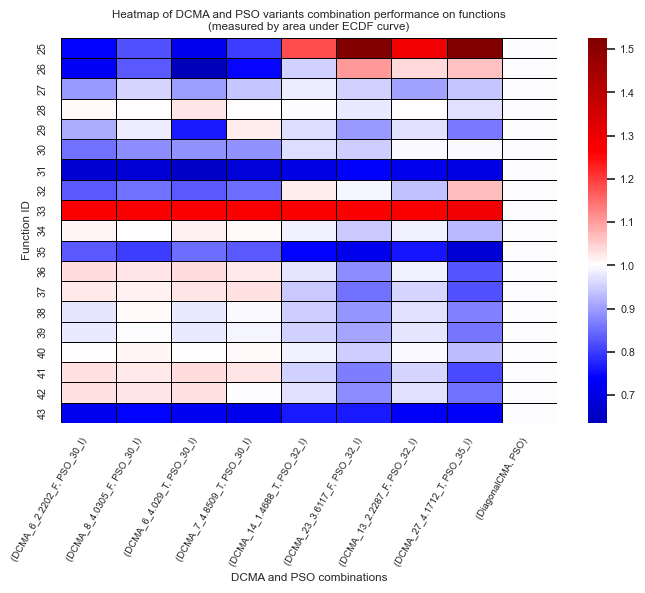

In [18]:
ax = sns.heatmap(df_tune_n2, xticklabels=1, cmap="seismic", center=1, linewidths=0.5, linecolor='black')
ax.set_xlabel('DCMA and PSO combinations')
ax.set_ylabel('Function ID')
sns.set(font_scale=0.7)
ax.set_title('Heatmap of DCMA and PSO variants combination performance on functions\n(measured by area under ECDF curve)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize=7)
figure = plt.gcf()  # get current figure
#figure.set_tight_layout(True)
figure.set_size_inches(8,5)
plt.savefig('ioh_logs_tune/new_algo2/hmap_tune_overall_n2f.pdf', bbox_inches='tight')
plt.show()